In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

Satelli sampling means variance based sampling, but not a good measure for non-uniform distribution. Advantage: just extends series further if you want to increase number of samples
Parallelization of sampling --> batch run (concurrent)

# Added modules

In [ ]:
def get_theta(x, mu, sigma):
    """
    x: fraction of similar neighbours
    mu: optimal fraction of similar neighbours
    sigma: acceptance range
    """
    theta = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return theta

In [ ]:
def gaussian_function(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Example usage:
x_values = np.linspace(0, 1, 100)
mu = 0.5  # Peak in the middle
sigma = 0.6  # Controls the width

y_values = gaussian_function(x_values, mu, sigma)

# You can plot the function to visualize it
import matplotlib.pyplot as plt

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Gaussian Function with Peak at {mu}')
plt.show()

# Sobol Sensitivity Analysis

In [2]:
from SALib.sample import saltelli
from SALib.analyze import sobol

In [81]:
import modules as modules
import model as model
from model import Schelling

def schelling_SA(num_steps, minority_pc, property_value_weight, alpha, mu_theta, sigma_theta, density):

    # initialize model
    models = Schelling(
        property_value_func=modules.property_value_quadrants,
        income_func=modules.income_func,
        desirability_func=modules.desirability_func,
        utility_func=modules.utility_func,
        price_func=modules.price_func,
        compute_similar_neighbours=modules.compute_similar_neighbours,
        calculate_gi_star = modules.calculate_gi_star,
        height=20,
        width=20,
        radius=1,
        density=density,
        minority_pc=minority_pc,
        alpha=alpha,
        income_scale=1.5, # the scale by which the income is higher than the property value
        property_value_weight=property_value_weight,
        mu_theta = mu_theta,
        sigma_theta = sigma_theta,
        seed=42)

    # Run the model for a certain number of steps
    for _ in range(num_steps):
        models.step()

    # call necessary data collectors
    agent_data = models.datacollector.get_agent_vars_dataframe()
    model_data_entropy = models.datacollector.get_model_vars_dataframe()
    
    # Compute mean and standard deviation of entropies over time per run
    desirability_entropy = model_data_entropy['Desirability entropy'].to_numpy()
    # desirability_entropy_std = model_data_entropy['Desirability entropy'].std()

    agent_entropy = model_data_entropy['Agent entropy'].to_numpy()
    # agent_entropy_std = model_data_entropy['Agent entropy'].std()
    print(agent_entropy)
    # Compute mean and standard deviation of utility per time step over each agent 
    utility_mean = agent_data.groupby(level='Step')['Utility'].mean()
    utility_std = agent_data.groupby(level='Step')['Utility'].std()
    
    # Compute mean and standard deviation of utility over time 
    utility_mean = pd.DataFrame(utility_mean).to_numpy()
    utility_std = pd.DataFrame(utility_std).to_numpy()

    return np.array(desirability_entropy), np.array(agent_entropy), np.array(utility_mean), np.array(utility_std)

In [82]:
# Step 1: Problem definition
problem = {
    'num_vars': 6,
    'names': ['density', 'minority_pc', 'property_value_weight', 'alpha', 'mu_theta', 'sigma_theta'],
    'bounds': [[0,1], [0,1], [0,1], [0,1], [0,1], [0,1]]
}

# Step 2: Generate samples 
samples = saltelli.sample(problem, 1) #2**5) #2024

/var/folders/v9/l1nzr55125v697bcr39l01hr0000gn/T/ipykernel_56600/732152587.py:9: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples = saltelli.sample(problem, 1) #2**5) #2024
/Users/kayamarlenedisselkamp/.local/share/virtualenvs/ABM-Notebooks-0-1-OzA5lFMJ/lib/python3.11/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1) is equal to `2^n`.
        
  warnings.warn(msg)


In [83]:
# Step 3: evaluate the model for the different parameter settings 
results = [schelling_SA(4, *sample) for sample in samples]

/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.65787579 0.66604704 0.66654065 0.66548975]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.7818206  0.813838   0.82623432 0.83003486]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.65787579 0.66561322 0.67552102 0.66672431]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.65787579 0.66318529 0.67376142 0.67424798]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.65787579 0.64364659 0.63001119 0.6234472 ]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.65787579 0.66197853 0.66411426 0.66151786]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.78161713 0.82824231 0.88569956 0.81486954]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.78161713 0.81797401 0.85427082 0.87950434]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.60555735 0.4641224  0.46744805 0.44241625]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.60555735 0.44145514 0.45686916 0.44327685]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.60555735 0.70540901 0.67369615 0.70294973]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.60555735 0.45618146 0.45644876 0.45837567]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.7818206  0.60641107 0.5625466  0.54563275]


/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:38: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:146: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:152: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  # for _, pos in self.grid.coord_iter():
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling 

[       nan 0.60555735 0.4475583  0.43234044 0.44863294]


In [101]:
# Step 4: turn results into processable format
def preprocessing_arrays(result):
    array1, array2, array3, array4 = zip(*result)

    # Flatten the arrays to 1D
    flattened_results_1 = [array.flatten() for array in array1]   
    flattened_results_2 = [array.flatten() for array in array2]
    flattened_results_3 = [array.flatten() for array in array3]    
    flattened_results_4 = [array.flatten() for array in array4]     

    # Convert the list of 1D arrays to a 2D numpy array and transpose it
    results_array_1 = np.array(flattened_results_1).T
    results_array_2 = np.array(flattened_results_2).T
    results_array_3 = np.array(flattened_results_3).T
    results_array_4 = np.array(flattened_results_4).T

    return results_array_1, results_array_2, results_array_3, results_array_4

desirability_entropy, agent_entropy, utility_mean, utility_std = preprocessing_arrays(results)

In [105]:
# Step 5: Analyze results for different quantities
sobol_indices_desirability_entropy = [sobol.analyze(problem,y) for y in np.array(desirability_entropy)]
#print(sobol_indices_desirability_entropy)

sobol_indices_agent_entropy = [sobol.analyze(problem,y) for y in np.array(agent_entropy)]
#print(sobol_indices_agent_entropy)

sobol_indices_mean_utility = [sobol.analyze(problem,y) for y in np.array(utility_mean)]
#print(sobol_indices_mean_utility)

sobol_indices_std_utility = [sobol.analyze(problem,y) for y in np.array(utility_std)]
#print(sobol_indices_std_utility)

In [106]:
S1s = np.array([s['S1'] for s in sobol_indices_desirability_entropy])

'prediction_interval = 95\n\nax0.fill_between(np.arange(0, 5, 1),\n                 np.percentile(sobol_indices_desirability_entropy, 50 - prediction_interval/2., axis=0),\n                 np.percentile(sobol_indices_desirability_entropy, 50 + prediction_interval/2., axis=0),\n                 alpha=0.5, color=\'black\',\n                 label=f"{prediction_interval} % prediction interval")\n\nax0.set_xlabel("x")\nax0.set_ylabel("y")\nax0.legend(title=r"$y=a+b\\cdot x^2$",\n           loc=\'upper center\')._legend_box.align = "left"\n\nplt.show()'

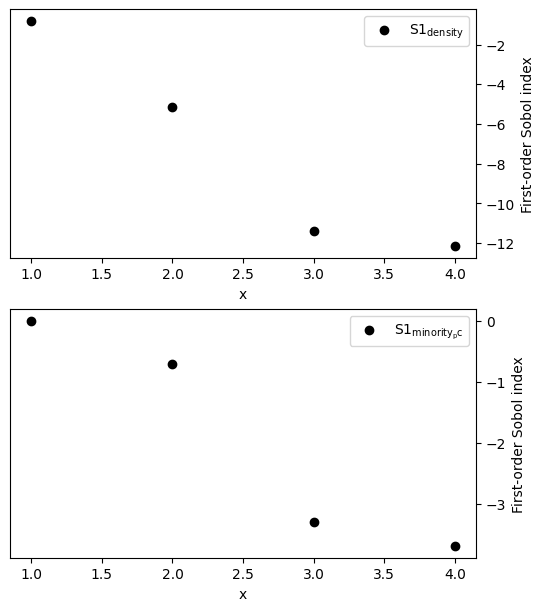

In [124]:
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

#ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

for i, ax in enumerate([ax1, ax2]):
    ax.scatter(np.arange(0, 5, 1), S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(problem["names"][i]),
            color='black')
    ax.set_xlabel("x")
    ax.set_ylabel("First-order Sobol index")

    #ax.set_ylim(0, 1.04)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.legend(loc='upper right')

#ax0.plot(np.arange(0, 5, 1), np.mean(sobol_indices_desirability_entropy), label="Mean", color='black')

# in percent
"""prediction_interval = 95

ax0.fill_between(np.arange(0, 5, 1),
                 np.percentile(sobol_indices_desirability_entropy, 50 - prediction_interval/2., axis=0),
                 np.percentile(sobol_indices_desirability_entropy, 50 + prediction_interval/2., axis=0),
                 alpha=0.5, color='black',
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.legend(title=r"$y=a+b\cdot x^2$",
           loc='upper center')._legend_box.align = "left"

plt.show()"""

# BIN 

In [44]:
def parabola(x, a, b):
    """Return y = a + b*x**2."""
    return a + b*x**2

problem = {
    'num_vars': 2,
    'names': ['a', 'b'],
    'bounds': [[0, 1]]*2
}

# sample
param_values = saltelli.sample(problem, 2**6)

# evaluate
x = np.linspace(-1, 1, 100)
y = np.array([parabola(x, *params) for params in param_values])

# analyse
sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]

/var/folders/v9/l1nzr55125v697bcr39l01hr0000gn/T/ipykernel_56600/570199526.py:12: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2**6)


In [43]:
print([parabola(x, *params) for params in param_values])

[(array([0.421875  , 0.40593913, 0.39032847, 0.37504304, 0.36008284,
       0.34544785, 0.33113809, 0.31715354, 0.30349422, 0.29016012,
       0.27715125, 0.26446759, 0.25210916, 0.24007595, 0.22836796,
       0.21698519, 0.20592765, 0.19519532, 0.18478822, 0.17470634,
       0.16494969, 0.15551825, 0.14641204, 0.13763105, 0.12917528,
       0.12104473, 0.1132394 , 0.1057593 , 0.09860442, 0.09177476,
       0.08527032, 0.0790911 , 0.07323711, 0.06770833, 0.06250478,
       0.05762645, 0.05307335, 0.04884546, 0.0449428 , 0.04136536,
       0.03811314, 0.03518614, 0.03258437, 0.03030781, 0.02835648,
       0.02673037, 0.02542948, 0.02445382, 0.02380337, 0.02347815,
       0.02347815, 0.02380337, 0.02445382, 0.02542948, 0.02673037,
       0.02835648, 0.03030781, 0.03258437, 0.03518614, 0.03811314,
       0.04136536, 0.0449428 , 0.04884546, 0.05307335, 0.05762645,
       0.06250478, 0.06770833, 0.07323711, 0.0790911 , 0.08527032,
       0.09177476, 0.09860442, 0.1057593 , 0.1132394 , 0.121

In [ ]:
y.T

In [ ]:
sobol_indices

In [ ]:
for params in param_values:
    print(*params)

In [ ]:
"""# Step 3: Run the model for generated samples
import model
import modules

# First define the model such that it runs for a specified number of time steps in a function 
def run_schelling_model(property_value_func,
                        income_func,
                        desirability_func,
                        utility_func,
                        price_func,
                        compute_similar_neighbours,
                        height,
                        width,
                        radius,
                        params,
                        #density,
                        #minority_pc,
                        #alpha,
                        #property_value_weight,
                        #mu_theta,
                        #sigma_theta,
                        seed,
                        num_steps):
    # Initialize the model
    model_instance = model.Schelling(
        property_value_func=property_value_func,
        income_func=income_func,
        desirability_func=desirability_func,
        utility_func=utility_func,
        price_func=price_func,
        compute_similar_neighbours=compute_similar_neighbours,
        height=height,
        width=width,
        radius=radius,
        density=params[0], #density,
        minority_pc=params[1], #minority_pc,
        alpha=params[2], #alpha,
        income_scale=1.5, # the scale by which the income is higher than the property value
        property_value_weight=params[3], #property_value_weight,
        mu_theta=params[4], #mu_theta,
        sigma_theta=params[5],
        seed=seed
    )

    # Run the model for the specified number of steps and collect entropy values
    agent_entropies = []
    desirability_entropies = []
    for _ in range(num_steps):
        model_instance.step()
        agent_entropies.append(model_instance.agent_entropy)
        desirability_entropies.append(model_instance.desirability_entropy)

    # Compute mean and standard deviation of entropy
    agent_entropy_mean = np.mean(agent_entropies)
    agent_entropy_std = np.std(agent_entropies)

    desirability_entropy_mean = np.mean(desirability_entropies)
    desirability_entropy_std = np.std(desirability_entropies)

    # get data from data collectors
    # model_data = model_instance.datacollector.get_model_vars_dataframe()
    agent_data = model_instance.datacollector.get_agent_vars_dataframe()
    print(agent_data)
    # compute mean utility and std over time
    utility_mean = agent_data.groupby(level='Step')['Utility'].mean()
    utility_std = agent_data.groupby(level='Step')['Utility'].std()
    
    # compute average utility for this run
    
    
    # Combine the results into a single DataFrame for better readability
    #utility_stats = pd.DataFrame({
     #   'Mean Utility': utility_mean,
     #   'Standard Deviation Utility': utility_std
    #})

    # Return the model instance and entropy values
    return utility_mean, utility_std#agent_entropy_mean, agent_entropy_std, desirability_entropy_mean, desirability_entropy_std

# Exemplory use
# Example of calling the function with specific parameters
model_result = run_schelling_model(
    property_value_func=modules.property_value_quadrants,
    income_func=modules.income_func,
    desirability_func=modules.desirability_func,
    utility_func=modules.utility_func,
    price_func=modules.price_func,
    compute_similar_neighbours=modules.compute_similar_neighbours,
    height=20,
    width=20,
    radius=1,
    density=0.8,
    minority_pc=0.2,
    alpha=0.5,
    seed=42,
    num_steps=5
)"""

In [ ]:
"""# Next compute the model for the different parameter settings 
Y = run_schelling_model(property_value_func=modules.property_value_quadrants,
    income_func=modules.income_func,
    desirability_func=modules.desirability_func,
    utility_func=modules.utility_func,
    price_func=modules.price_func,
    compute_similar_neighbours=modules.compute_similar_neighbours,
    height=20,
    width=20,
    radius=1,
    params=samples[0],
    seed=42,
    num_steps=4)"""

In [ ]:
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol

# Step 1: Define the problem
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[0, 1], [0, 1], [0, 1]]
}

# Step 2: Generate samples
param_values = saltelli.sample(problem, 1000)

# Step 3: Evaluate the model
# Define your model (this is an example model)
def model(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    x3 = X[:, 2]
    return x1 + x2 + x3

# Run the model for generated samples
Y = model(param_values)

# Step 4: Perform Sobol sensitivity analysis
sobol_indices = sobol.analyze(problem, Y, print_to_console=True)

# Step 5: Extract results
Si = sobol_indices

# Print the first-order, second-order, and total-order sensitivity indices
print("First-order indices:", Si['S1'])
print("Second-order indices:", Si['S2'])
print("Total-order indices:", Si['ST'])

In [ ]:
""import mesa
import numpy as np
import mesa
import random
import matplotlib.pyplot as plt
import modules

NO_NEIGHBORS_THETA = 0.5

class SchellingAgent(mesa.Agent):
    """
    Schelling segregation agent
    """

    def __init__(self, unique_id, model, agent_type, budget):
        """
        Create a new Schelling agent.

        Args:
           unique_id: Unique identifier for the agent.
           agent_type: Indicator for the agent's type (minority=1, majority=0)
           budget: Budget for the agent
        """
        super().__init__(unique_id, model)
        self.type = agent_type
        self.budget = budget
        self.utility = 0.5
        self.segregation = None
        self.move_counter = 0

    def calc_theta(self):
        # Calculate theta using the model's get_theta method
        self.segregation = modules.get_theta(self.model, self.pos, self.type)

    def step(self):
        """
        Step for agent to move
        In a step an agent will:
            1. Find available properties to move to
            2. Calculate their utility for each property
            3. If the property with the highest utility has a higher utility than the current property, move there
            4. Update the utility of the agent in their new location
        """
        # update utility
        self.utility = self.model.utility_func(self.model, self, self.pos)
        
        self.calc_theta()

        # find the available properties to move to
        available_cells = self.model.find_available_cells(self)
                
        if len(available_cells) < 0:
            return
        
        # list all utilities of available properties
        move_util = []
        for cell in available_cells:
            # store as (cell, utility) tuple
            move_util.append((cell, self.model.utility_func(self.model, self, cell)))
        
        # sort by utility
        move_util.sort(key=lambda x: x[1], reverse=True)
        
        # move if utility is higher than current
        if move_util[0][1] > self.utility:
            self.model.grid.move_agent(self, move_util[0][0])
            # update utility
            self.utility = move_util[0][1]
            self.move_counter += 1


class Schelling(mesa.Model):
    """
    Model class for the Schelling segregation model.
    """

    def __init__(
        self,
        property_value_func,
        income_func,
        desirability_func,
        utility_func,
        price_func,
        ##########
        compute_similar_neighbours,
        ##########
        height=20,
        width=20,
        radius=1,
        density=0.8,
        minority_pc=0.2,
        alpha=0.5,
        income_scale=1.5, # the scale by which the income is higher than the property value
        property_value_weight=0.1,
        mu_theta = 0.4,
        sigma_theta = 0.6,
        agent_entropy = None,
        desirability_entropy = None, 
        seed=None
    ):
        """
        Create a new Schelling model.

        Args:
            width, height: Size of the space.
            density: Initial chance for a cell to be populated
            minority_pc: Chance for an agent to be in minority class
            radius: Search radius for checking similarity
            seed: Seed for reproducibility
            property_value: Value for the property
        """

        super().__init__(seed=seed)
        self.utility_func = utility_func
        self.price_func = price_func
        self.desirability_func = desirability_func
        self.prop_value_weight = property_value_weight
        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.radius = radius
        self.alpha = alpha
        self.mu_theta = mu_theta
        self.sigma_theta = sigma_theta
        ############
        self.agent_entropy = agent_entropy
        self.desirability_entropy = desirability_entropy
        #############
        #############
        self.compute_similar_neighbours = compute_similar_neighbours
        self.neighbor_similarity_counter = {}
        #############

        self.schedule = mesa.time.RandomActivation(self)
        self.grid = mesa.space.SingleGrid(width, height, torus=True)

        # Property Value Layer
        self.property_value_layer = property_value_func(name="property_values", width=width, height=height)
        self.grid.add_property_layer(self.property_value_layer)

        # Desirability Layer
        self.desirability_layer = mesa.space.PropertyLayer("desirability", width, height, 0.5)
        # for _, pos in self.grid.coord_iter():
        #     self.desirability_layer[pos] = 1
        self.grid.add_property_layer(self.desirability_layer)
        
        # Interested Agents Counter Layer
        self.interested_agents_layer = mesa.space.PropertyLayer("interested_agents", width, height, 0)
        # for _, pos in self.grid.coord_iter():
        #     self.interested_agents_layer[pos] = 0
        self.grid.add_property_layer(self.interested_agents_layer)
        
        # Utility Layer
        self.utility_layer = mesa.space.PropertyLayer("utility", width, height, 0.5) 
        self.grid.add_property_layer(self.utility_layer)

        ##############
        #self.datacollector_attempt = mesa.DataCollector(
        #    model_reporters={"Desirability entropy": "desirability_entropy", "Agent entropy": "agent_entropy"}
        #)
        ##############

        #Data Collectors
        self.datacollector = mesa.DataCollector(
            agent_reporters={"Utility": "utility", "Segregation":"segregation", "Moves":"move_counter"}, model_reporters={"Desirability entropy": "desirability_entropy", "Agent entropy": "agent_entropy", "Desirability": self.desirability_layer.data.tolist}  # Collect the utility of each agent
        ) # added entropy collection to data collectors

        # Set up agents
        for _, pos in self.grid.coord_iter():
            if self.random.random() < self.density:
                agent_type = 1 if self.random.random() < self.minority_pc else 0
                budget = income_func(scale=income_scale)
                agent = SchellingAgent(self.next_id(), self, agent_type, budget)
                self.grid.place_agent(agent, pos)
                self.schedule.add(agent)

        self.datacollector.collect(self)

    def find_available_cells(self, agent):
        available_cells = []
        for _, pos in self.grid.coord_iter():
            if self.grid.is_cell_empty(pos):
                available_cells.append(pos)        
        return available_cells

    def step(self):
        """
        Run one step of the model.
        """
        # Set the count of agents who like to move somewhere to 0 for all cells
        self.interested_agents_layer.set_cells(0)

        ########
        self.neighbor_similarity_counter.clear()
        ########

        for agent in self.schedule.agents:
            # Iterate over cells and compare utility to current location, add to interested_agents_layer if better
            for _, loc  in self.grid.coord_iter():
                utility = self.utility_func(self, agent, loc)
                
                if utility > agent.utility:
                    self.interested_agents_layer.modify_cell(loc, lambda v: v + 1)

        ###### ADDED #############
            # Compute number of agents with the same number of similar neighbours 
            similar_neighbors = self.compute_similar_neighbours(self, agent)
            if similar_neighbors not in self.neighbor_similarity_counter:
                self.neighbor_similarity_counter[similar_neighbors] = 0
            self.neighbor_similarity_counter[similar_neighbors] += 1

        # Compute total number of agents included
        total_agents = len(self.schedule.agents) #sum(self.neighbor_similarity_counter.values())

        # Compute agent entropy and store it 
        current_agent_entopy = 0
        for _, p in self.neighbor_similarity_counter.items():
            if p > 0:  # To avoid domain error for log(0)
                probability = p / total_agents
                value = probability * np.log10(probability)
                current_agent_entopy += value
        self.agent_entropy = -current_agent_entopy
        #############################
        
        # Set desirability layer to the proportion of interested agents
        #num_agents = len(self.schedule.agents)
        self.desirability_layer.set_cells(
            self.desirability_func(self, prop_value_weight=self.prop_value_weight)
        )
        
        ##### Compute entropy for desirability ###########
        desirability_current_entropy = modules.compute_entropy(self)
        self.desirability_entropy = desirability_current_entropy
        ############################

        self.schedule.step()
        self.datacollector.collect(self)

        ###################
        #self.datacollector_attempt.collect(self)
        ###################

# import modules
# # Create and run the model
# model = Schelling(
    # property_value_func=modules.property_value_quadrants,
    # utility_func=modules.utility_func,
    # price_func=modules.price_func,
    # height=20,
    # width=20,
    # radius=1,
    # density=0.8,
    # minority_pc=0.2,
    # alpha=0.5,
    # seed=42
# )

# # Run the model for a certain number of steps
# for i in range(5):
    # print(i)
    # model.step()

# # Retrieve the collected data
# agent_data = model.datacollector.get_agent_vars_dataframe()
# model_data = model.datacollector.get_model_vars_dataframe()

# print(agent_data)

"""### ADDED ####
import modules
# # Create and run the model
model = Schelling(
     property_value_func=modules.property_value_quadrants,
     income_func=modules.income_func,
     desirability_func=modules.desirability_func,
     utility_func=modules.utility_func,
     price_func=modules.price_func,
     compute_similar_neighbours=modules.compute_similar_neighbours,
     height=20,
     width=20,
     radius=1,
     density=0.8,
     minority_pc=0.2,
     alpha=0.5,
     seed=42
 )

# # Run the model for a certain number of steps
for i in range(5):
     print(i)
     print(model.agent_entropy)
     print(model.desirability_entropy)
     model.step()"""""